# Window-Based Detection using KAZE Descriptor Featuring Matching

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import time
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn import metrics as sk_metrics
from sklearn.model_selection import RandomizedSearchCV
import pickle as pkl

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

from dataset import *
from descriptor import *
from SlidingWindow import *
from BagOfWords import *

In [2]:
# Global Variables
run_sliding_window = False

curr_wd = os.getcwd()
example_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', '004.jpg')
example_full_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', '000.jpg')
provided_annot_path = os.path.join(curr_wd, 'cache_anno/', 'classification', 'provided_annots.pkl')

with open(provided_annot_path, 'rb') as f:
    provided_annots = pickle.load(f)

## Sliding Window

In order to perform window based detection on an image, we need to construct a sliding window subroutine in order to iterate over windows in an image. In the following demonstration, a multiscale sliding window routine using image pyramids is displayed

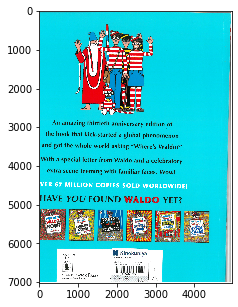

In [3]:
# Load example image 
example_image = plt.imread(example_path)
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(example_image)

In [4]:
# Sliding window routine
window_size = (100, 100)
if run_sliding_window: # Toggle demo using this variable
    for sub_image in image_pyramid(example_image, scale=1.5):
        for coordinates, window in sliding_window(sub_image, step_size=100, window_size=window_size):
            # NOTE: Can apply sub routine to process each image here

            # Extract coordinates of current bounding box
            y, x, y_end, x_end = coordinates

            sub_image_copy = sub_image.copy() 
            cv2.rectangle(sub_image_copy, (x, y), (x_end, y_end), (0, 255, 0), 2)
            cv2.imshow("Example", sub_image_copy)
            cv2.waitKey(1)
            time.sleep(0.025)

# NOTE: Running this cell block may crash the kernel. Only do so to visualise the results of sliding window

### Load Dataset

Loads the patches from the `datasets/train/positives` and `datasets/train/extra` as training data for classifier model. The patches are in the type `ndarray`
<br> *detection calss allowed:* </br>
<br> **waldo_face_front** </br>
<br> **waldo_face_side** </br>
<br> **waldo_body_full** </br>
<br> **waldo_body_half** </br>
<br> **wenda_face_front** </br>
<br> **wenda_body_full** </br>
<br> **wenda_body_half** </br>
<br> **wizard_face_front** </br>
<br> **wizard_body_full** </br>
<br> **wizard_body_half** </br>
<br> **other_face_front** </br>
<br> **other_body_full** </br>
<br> **other_body_half**</br>

In [5]:
# prepare annotations:
extract_provided_annots()
extract_extra_annots()

In [7]:
# prepare list of images to use
img_lst = []
img_lst_pth = os.path.join(curr_wd, 'datasets', 'ImageSets', 'images.txt')
with open(img_lst_pth, 'r') as fp:
    contents = fp.readlines()
    for l in contents:
        file_name = l.strip()
        if file_name and file_name != '000': # exclude the example image
            img_lst.append(file_name)

In [ ]:
# generate the dataset
prepare_classification_dataset(img_lst, clean=True)

In [10]:
# Load data
# here we focus on faces
# neg_ratio control the number of negative instances
detection_class = ['waldo_face_front']
train_loader, valid_loader = prepare_classification_dataloader(detection_class, simple=True, neg_ratio=0.7)
train_instances, valid_instances = list(train_loader), list(valid_loader)

---num of training instances: 1632
---num of validation instances: 408


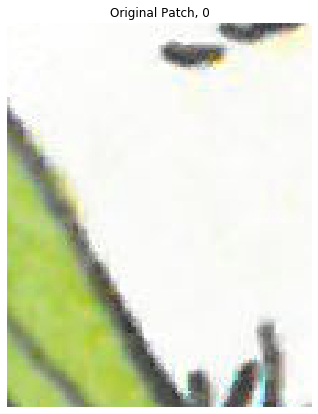

In [34]:
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.subplot(1,2,1)
plt.imshow(train_instances[0][0])
plt.axis('off')
plt.title('Original Patch, ' + str(train_instances[0][1]))

# Convert to RGB
def to_rgb(img):
    return img[:, :, ::-1]

train_images, train_labels = zip(*train_instances)
valid_images, valid_labels = zip(*valid_instances)

In [35]:
# Extract feature descriptors from training set
train_features = extract_features(train_images)
bag_of_words = cluster_features(train_features)
print('Number of KAZE descriptors:', len(train_features))

Number of KAZE descriptors: 91429


In [37]:
train_histograms = extract_histograms(train_images, bag_of_words)

### Train Classifier

After extracting the Bag Of Words from the training patches, we then train our classifer on the histogram vector features from training data patches, and test it on our validation patches

In [38]:
# Initialize the validation set
print('Number of validation examples: ', len(valid_images))

Number of validation examples:  408


In [47]:
val_histograms = extract_histograms(valid_images, bag_of_words)
val_labels = valid_labels

In [48]:
# Initialize classification model
# SVM Model
svm = SVC(kernel='linear', C=0.75, probability=True)
svm.fit(train_histograms, train_labels)

SVC(C=0.75, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [49]:
len(train_labels)

1632

In [51]:
val_predict = svm.predict(val_histograms)
precision = sk_metrics.precision_score(y_true=val_labels, y_pred=val_predict)
recall = sk_metrics.recall_score(y_true=val_labels, y_pred=val_predict)
f1_score = sk_metrics.f1_score(y_true=val_labels, y_pred=val_predict)
print('Precision: %.3f\nRecall: %.3f\nF1 Score: %.3f' % (precision, recall, f1_score))

Precision: 0.800
Recall: 0.667
F1 Score: 0.727


In [52]:
# XGBoost Model
# NOTE: XGB requires heavy tuning 
xgb = xgboost.XGBClassifier(learning_rate=0.001, n_estimators=250, max_depth=5)
xgb.fit(train_histograms, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [53]:
val_predict = xgb.predict(val_histograms)
precision = sk_metrics.precision_score(y_true=val_labels, y_pred=val_predict)
recall = sk_metrics.recall_score(y_true=val_labels, y_pred=val_predict)
f1_score = sk_metrics.f1_score(y_true=val_labels, y_pred=val_predict)
print('Precision: %.3f\nRecall: %.3f\nF1 Score: %.3f' % (precision, recall, f1_score))

Precision: 0.712
Recall: 0.561
F1 Score: 0.627


In [54]:
# Random Forest Model
rf = RandomForestClassifier()
rf.fit(train_histograms, train_labels)

/anaconda3/envs/Waldo/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [55]:
val_predict = rf.predict(val_histograms)
precision = sk_metrics.precision_score(y_true=val_labels, y_pred=val_predict)
recall = sk_metrics.recall_score(y_true=val_labels, y_pred=val_predict)
f1_score = sk_metrics.f1_score(y_true=val_labels, y_pred=val_predict)
print('Precision: %.3f\nRecall: %.3f\nF1 Score: %.3f' % (precision, recall, f1_score))

Precision: 0.872
Recall: 0.515
F1 Score: 0.648


### Sliding Window Scoring

We now use our trained classifer to score each window, and threshold windows that have scores beyond a certain benchmark

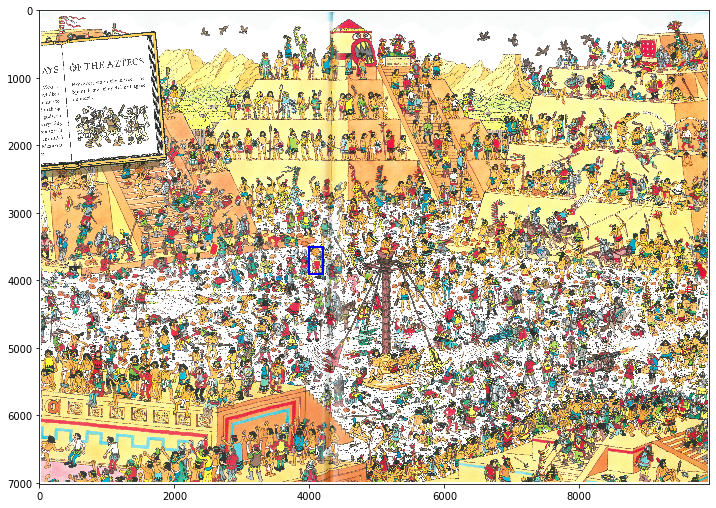

In [56]:
# Visualise window on training image
plt.rcParams['figure.figsize'] = (12.0, 12.0)
fig, ax = plt.subplots(1)

window_size = (200, 400)
step_size = 500

example_full = plt.imread(example_full_path)
ax.imshow(example_full)

rect = patches.Rectangle((4000, 3500), window_size[0], window_size[1], linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)

plt.show()

In [60]:
# Perform detection
detections = detect(example_full, bag_of_words, svm)
print('Number of Bounding Boxes Without Thresholding: ', len(detections))

Number of Bounding Boxes Without Thresholding:  18


In [61]:
grounf_truth = [0] * 4
for box in provided_annots['000.jpg']:
    coord, label = box
    if label[0] == 'waldo':
        ground_truth = coord

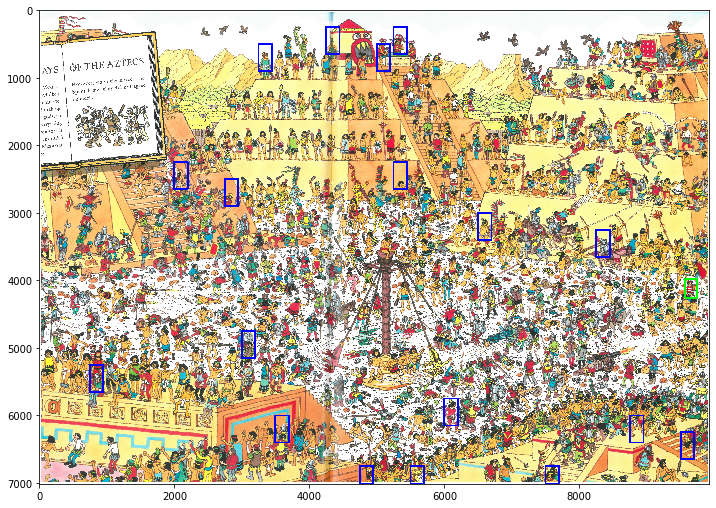

In [63]:
# Visualise detections
clone = example_full.copy()
for (x1, y1, x2, y2, score) in detections:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
cv2.rectangle(clone, (ground_truth[0], ground_truth[1]), (ground_truth[2], ground_truth[3]), (0, 255, 0), thickness=25)
plt.imshow(clone)